In [14]:
#%matplotlib inline
import ipympl
%matplotlib ipympl

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
import copy
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.create_river_mesh
import watershed_workflow.densify_rivers_hucs

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

# Read the watershed boundaries 

In [17]:
hucs = ['020401040301']#,'020401040302'] # This is the huc for Nevershink

# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)
crs = watershed_workflow.crs.daymet_crs() # Use the same projection than Daymet

_, ws = watershed_workflow.get_huc(sources['HUC'], hucs[0], crs)

my_hucs = []
for huc in hucs:
    _, ws = watershed_workflow.get_huc(sources['HUC'], huc, crs)
    my_hucs.append(ws)
    
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)


2022-12-08 22:09:50,398 - root - INFO: Using sources:
2022-12-08 22:09:50,400 - root - INFO: --------------
2022-12-08 22:09:50,401 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-12-08 22:09:50,401 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-12-08 22:09:50,402 - root - INFO: DEM: National Elevation Dataset (NED)
2022-12-08 22:09:50,403 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2022-12-08 22:09:50,403 - root - INFO: geologic structure: GLHYMPS version 2.0
2022-12-08 22:09:50,403 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2022-12-08 22:09:50,404 - root - INFO: soil thickness: None
2022-12-08 22:09:50,404 - root - INFO: meteorology: DayMet 1km
2022-12-08 22:09:50,405 - root - INFO: 
2022-12-08 22:09:50,406 - root - INFO: Loading HUC 020401040301
2022-12-08 22:09:50,406 - root - INFO: ---------

# Read the river reaches

In [18]:
include_rivers=True
ignore_small_rivers = False
prune_by_area_fraction = False

if include_rivers:
    # download/collect the river network within that shape's bounds    
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True, 
                                                include_catchments=True)
    
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq',
                                                ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area_fraction=prune_by_area_fraction,
                                                remove_diversions=True,
                                                remove_braided_divergences=True)

2022-12-08 22:09:53,802 - root - INFO: 
2022-12-08 22:09:53,803 - root - INFO: Loading Hydrography
2022-12-08 22:09:53,804 - root - INFO: ------------------------------
2022-12-08 22:09:53,804 - root - INFO: Loading streams in HUC 020401040301
2022-12-08 22:09:53,805 - root - INFO:          and/or bounds (1977558.8450891976, 242336.1425406865, 1992195.307388996, 256506.7749082209)
2022-12-08 22:09:53,806 - root - INFO:   Using Hydrography file "/Users/8n8/Documents/data_research/watershed_workflow/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb"
2022-12-08 22:09:53,828 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/8n8/Documents/data_research/watershed_workflow/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb' layer 'NHDFlowline' for streams in '(1977558.8450891976, 242336.1425406865, 1992195.307388996, 256506.7749082209)'
2022-12-08 22:09:55,325 - root - INFO:   Found total of 983 in bounds.
2022-12-08 22:09:55,326 - root - INFO:   

In [19]:
# Identify the main river

da_km2_rivers = []
for rr in rivers:
    da_km2_rivers.append(rr.properties['TotalDrainageAreaSqKm'])
da_km2_rivers = np.array(da_km2_rivers)
idx_largest = da_km2_rivers.argmax()

river = rivers[idx_largest]


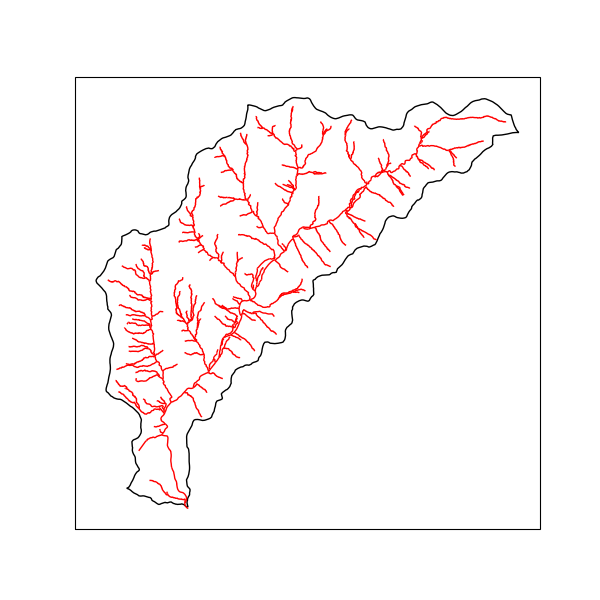

In [20]:
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs,fig)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(river, crs, ax=ax, color='red', linewidth=1)
plt.show()

## Estimate the width function

In [21]:
n_nodes = len(river)
d_to_outlet_m = []

for node in river.preOrder(): # Move    
    length_to_outlet=0
    for node_on_path in node.pathToRoot():
        length_to_outlet +=  node_on_path.segment.length
    d_to_outlet_m.append(length_to_outlet)
    node.properties['lenth to outlet']=length_to_outlet
    
d_to_outlet_m = np.array(d_to_outlet_m)

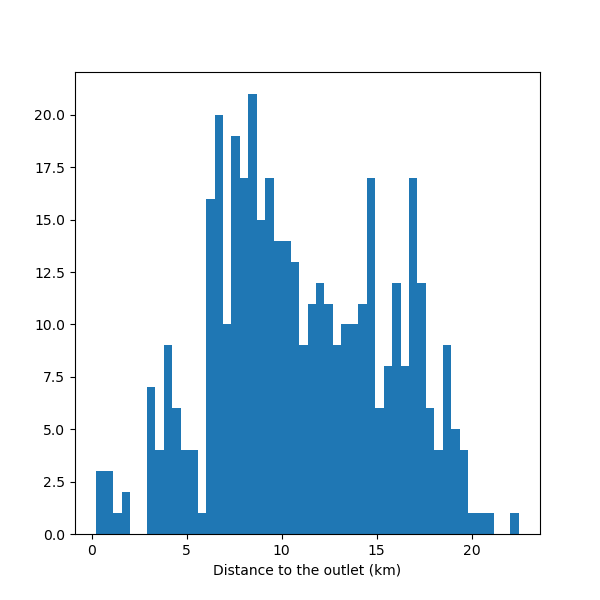

In [28]:
fig = plt.figure(figsize=figsize)
plt.hist(d_to_outlet_m/1000,50)
plt.xlabel('Distance to the outlet (km)')
plt.show()

# Refine the river network

In [23]:
rivers_orig = [rr.deep_copy() for rr in rivers] # mimicking the original
watershed_orig = copy.deepcopy(watershed) # keeping the original

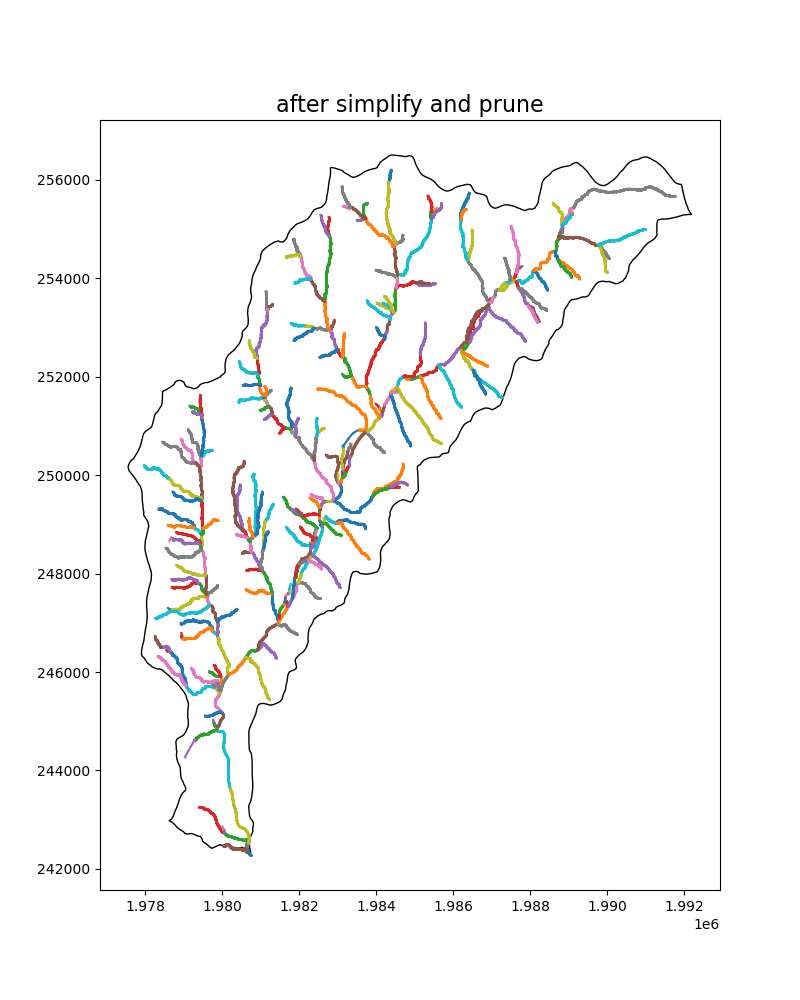

In [24]:
# quick glance at the problem
plt.rcParams['figure.figsize'] = [8, 10]

fig, axs = plt.subplots(1,1)

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs)
axs.set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs.plot(x,y,'-o',markersize=.5)

In [25]:
# simplify the geometry for a "nicer" discrete object
watershed_workflow.simplify(watershed, rivers, simplify_rivers=10,
                            snap=False, cut_intersections=True)

# processing originals to match structure of river tree as simplified while keeping the high resolution
watershed_workflow.simplify(watershed_orig, rivers_orig, simplify_rivers=0.1,
                            snap=False, cut_intersections=True)

# for plotting purpose
rivers_simplified=[rr.deep_copy() for rr in rivers] 
river_simplified = rivers_simplified[idx_largest]
watershed_simplified=copy.deepcopy(watershed) 

2022-12-08 22:10:59,301 - root - INFO: 
2022-12-08 22:10:59,301 - root - INFO: Simplifying
2022-12-08 22:10:59,302 - root - INFO: ------------------------------
2022-12-08 22:10:59,303 - root - INFO: Simplifying rivers
2022-12-08 22:10:59,380 - root - INFO:   ...cleaned inner segment of length 7.92697 at centroid (1979872.693150918, 244891.57448693883)
2022-12-08 22:10:59,381 - root - INFO:   ...cleaned inner segment of length 6.42314 at centroid (1979772.1145630928, 244981.32765203837)
2022-12-08 22:10:59,382 - root - INFO:   ...cleaned inner segment of length 5.14888 at centroid (1979929.4830071514, 245585.74037763762)
2022-12-08 22:10:59,382 - root - INFO:   ...cleaned inner segment of length 5.82584 at centroid (1978574.835006807, 246432.03297713058)
2022-12-08 22:10:59,383 - root - INFO:   ...cleaned inner segment of length 7.32238 at centroid (1979947.1083571892, 245628.13478342563)
2022-12-08 22:10:59,384 - root - INFO:   ...cleaned inner segment of length 7.01381 at centroid (1

Dual/multiple section: type = <class 'shapely.geometry.multipoint.MultiPoint'>
 point = MULTIPOINT (1980585.0654543084 242418.25644401697, 1980575.5731585517 242422.07492129316)


RuntimeError: Dual/multiple intersection in a single seg... ugh!  Intersection is of type '<class 'shapely.geometry.multipoint.MultiPoint'>'

NameError: name 'watershed_simplified' is not defined

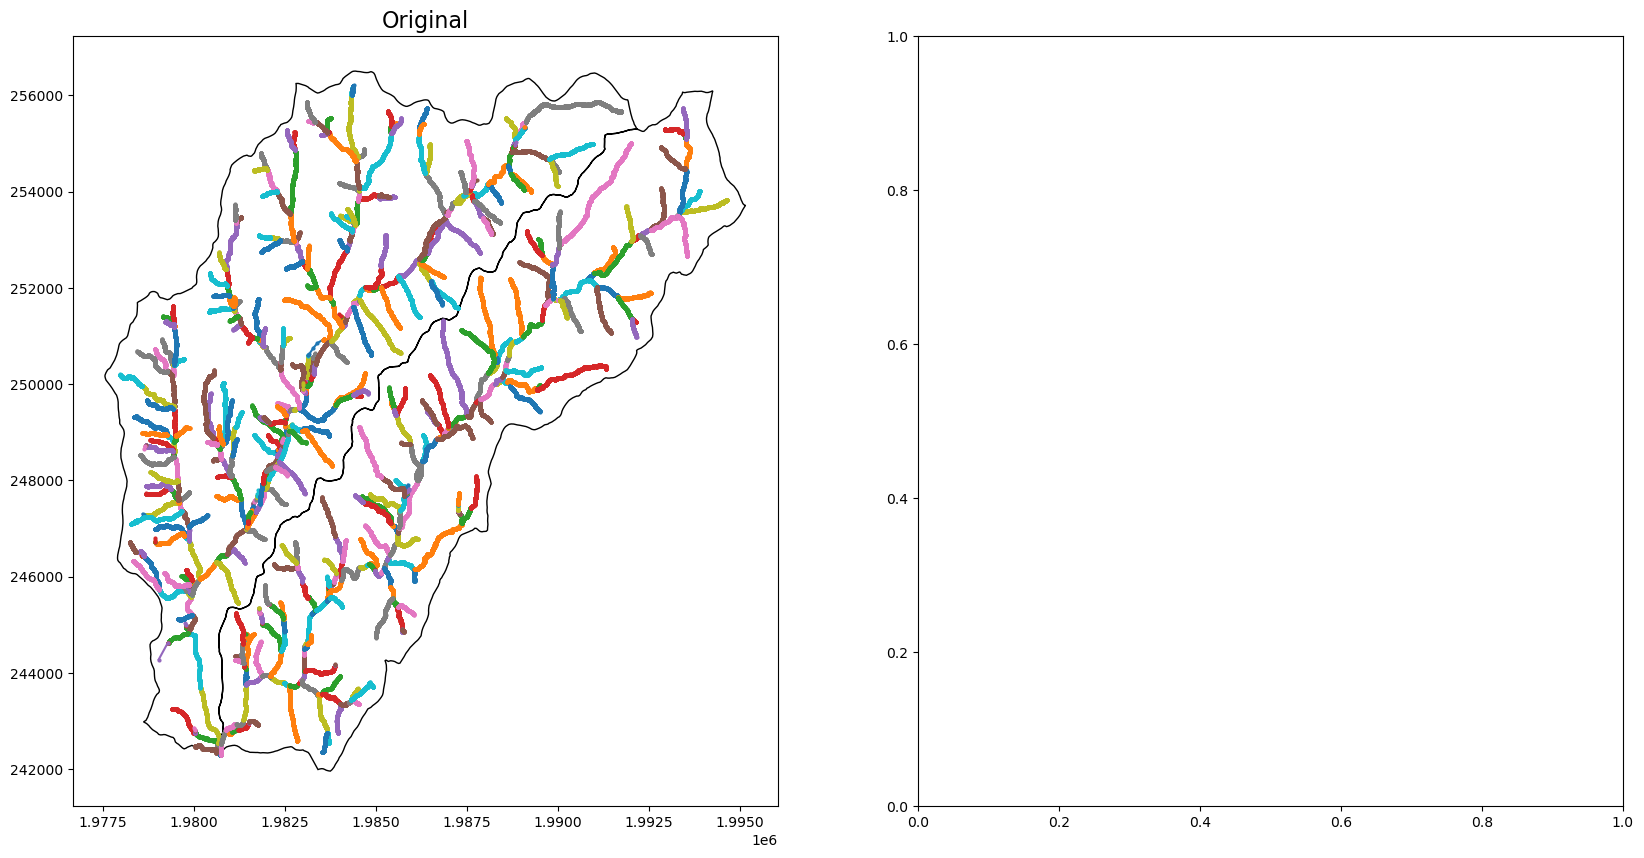

In [13]:
# quick glance at the problem

fig, axs = plt.subplots(1,2,figsize=[20,10])

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('Original',fontsize=16)
for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)
    
    
watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

In [106]:
#densify watershed
watershed_dens=watershed_workflow.densify_rivers_hucs.densify_hucs(watershed, watershed_orig, rivers, use_original= False,limit_scales=[0,25,100,50])

#densify river
rivers_dens=watershed_workflow.densify_rivers_hucs.densify_rivers(rivers, rivers, limit=30, use_original=False, treat_collinearity=True)

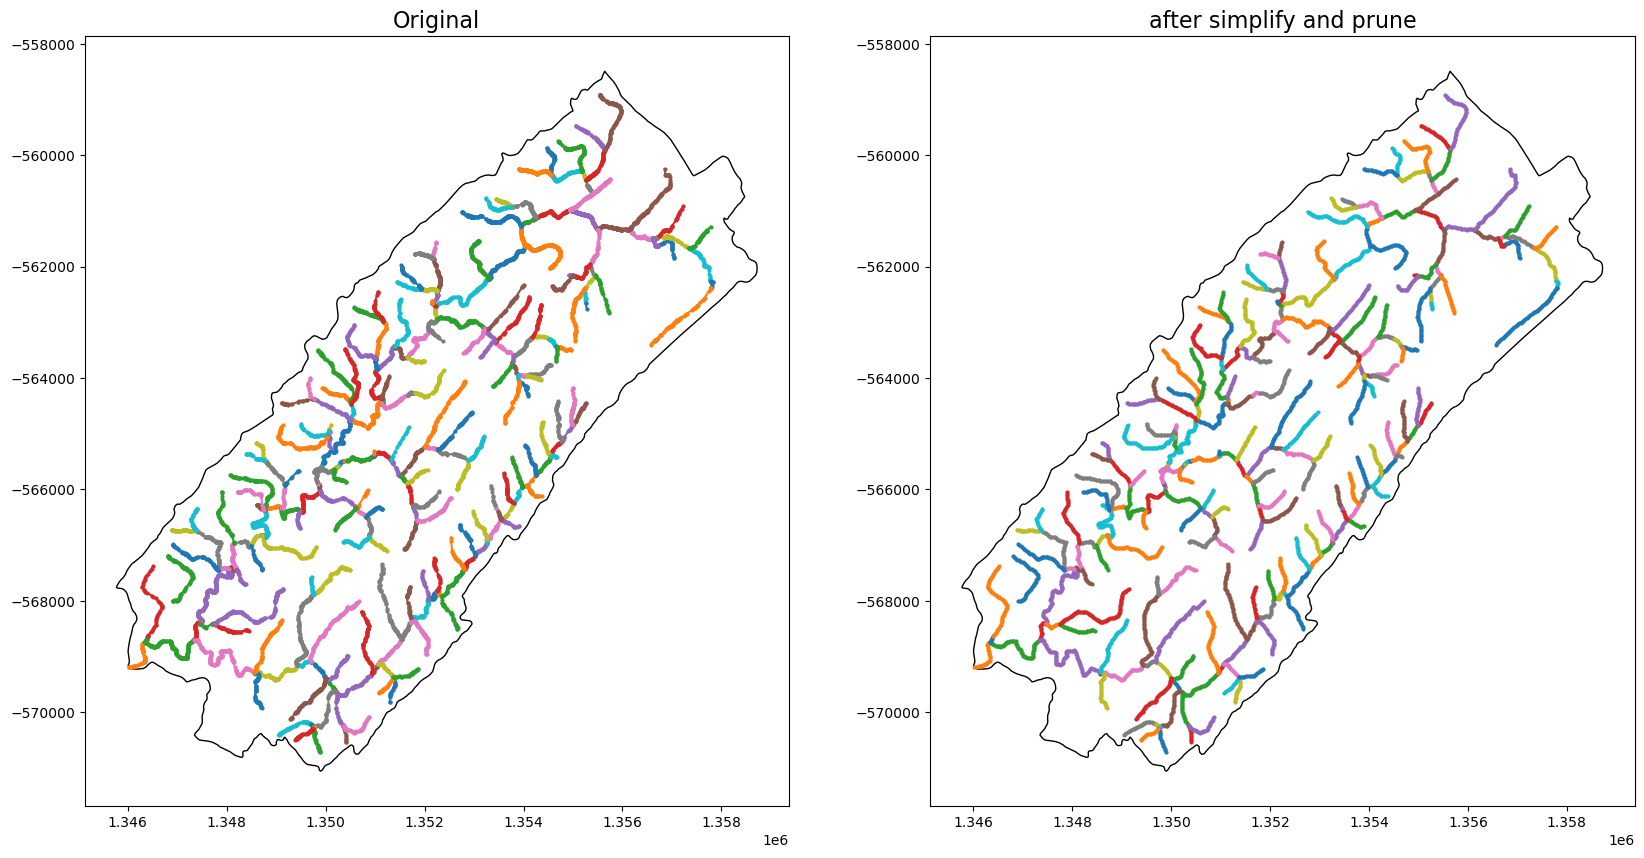

In [107]:
# quick glance at the problem

fig, axs = plt.subplots(1,2,figsize=[20,10])

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('Original',fontsize=16)
for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)
    
    
watershed_workflow.plot.hucs(watershed_dens, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_dens:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

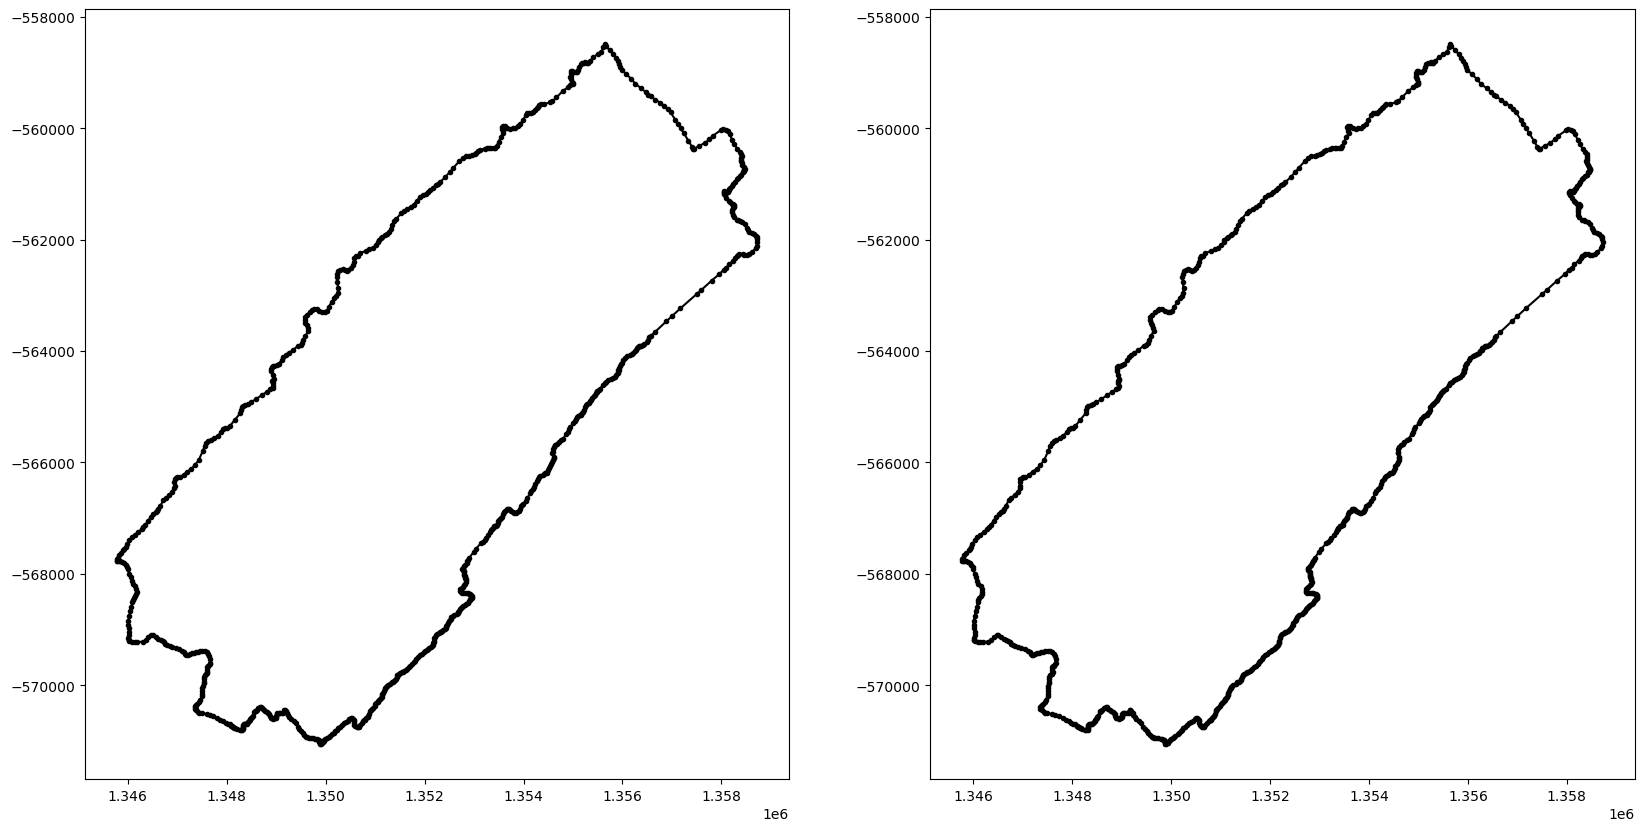

In [79]:
fig, axs = plt.subplots(1,2,figsize=[20,10])
axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k.-')
axs[1].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k.-')

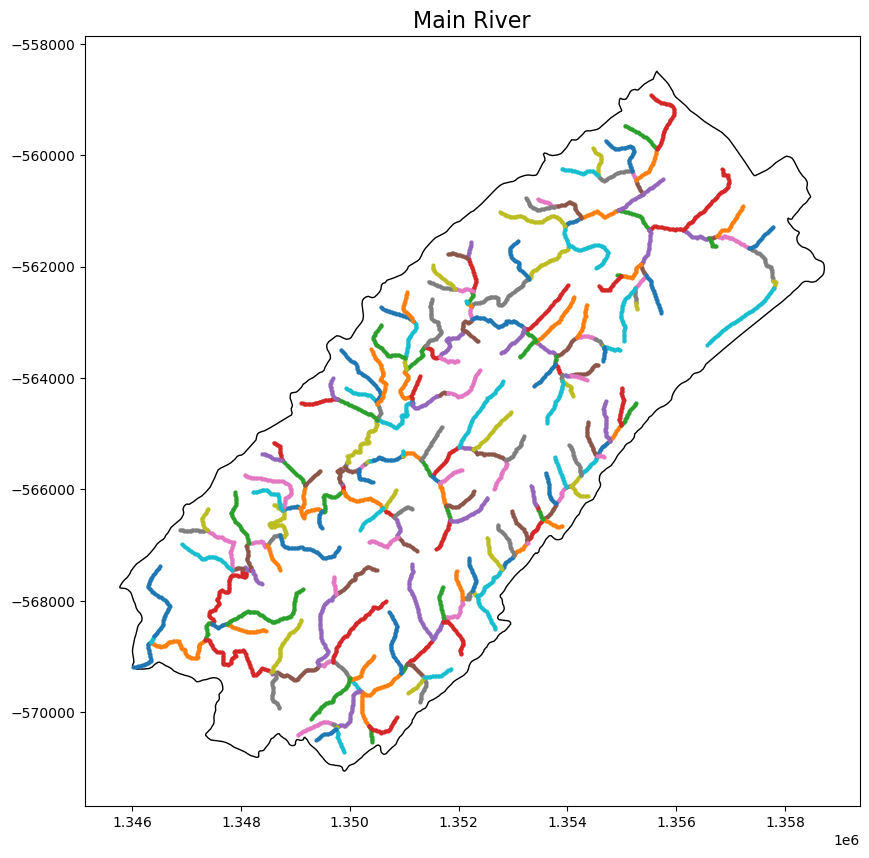

In [121]:
# Identify the main river

da_km2_rivers = np.array([rr.properties['TotalDrainageAreaSqKm'] for rr in rivers_dens]) 
idx_largest = da_km2_rivers.argmax()
main_river = rivers_dens[idx_largest]

# Plot the main river
fig, axs = plt.subplots(1,1,figsize=[10,10])

watershed_workflow.plot.hucs(watershed_dens, crs, 'k', axs)
axs.set_title('Main River',fontsize=16)
for node in main_river.preOrder():
    x,y=node.segment.xy 
    axs.plot(x,y,'-o',markersize=2)
        

In [254]:
n_nodes = len(river)
d_to_outlet_m = np.array([])

for node in main_river.preOrder(): # Move along the nodes   
    length_to_outlet = 0 
    for node_on_path in node.pathToRoot(): # flow from node root
        length_to_outlet +=  node_on_path.segment.length
    
    xy_coor = np.array(node.segment.xy)
    d = np.cumsum(np.linalg.norm([xy_coor[0,1:]-xy_coor[0,:-1],xy_coor[1,1:]-xy_coor[1,:-1]],axis =0))    
    node.properties['lenth to outlet'] = length_to_outlet - d[-1] # Distance from the downstream node of the segment
    d_to_outlet_m = np.concatenate((d_to_outlet_m, length_to_outlet - (d[-1] - d))) 
        

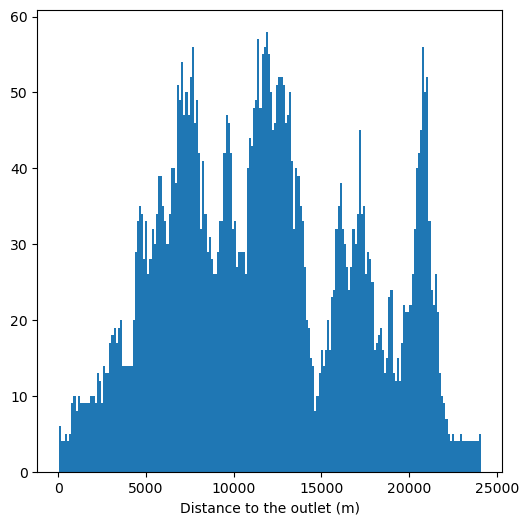

In [258]:
fig = plt.figure(figsize=figsize)
plt.hist(d_to_outlet_m,200)
plt.xlabel('Distance to the outlet (m)')
plt.show()

In [271]:
weights = np.ones_like(d_to_outlet_m)
n_bins = 100
bin_size_m = np.ceil(np.max(d_to_outlet_m)/n_bins)
bins_edges = np.arange(n_bins+1)*bin_size_m
bin_center = (bins_edges[1:]+bins_edges[:-1])/2

histogram_data = np.histogram(d_to_outlet_m, bins=bins_edges, weights=weights)


In [229]:
nodes = list(main_river.preOrder())
node = nodes[0]
xy_coor = np.array(node.segment.xy)
d = np.cumsum(np.linalg.norm([xy_coor[0,1:]-xy_coor[0,:-1],xy_coor[1,1:]-xy_coor[1,:-1]],axis =0))

print('Segment length = ' + str(node.segment.length))
print('Estimated segment length = ' + str(d[-1]))


Segment length = 712.9489526255543
Estimated segment length = 712.9489526255543


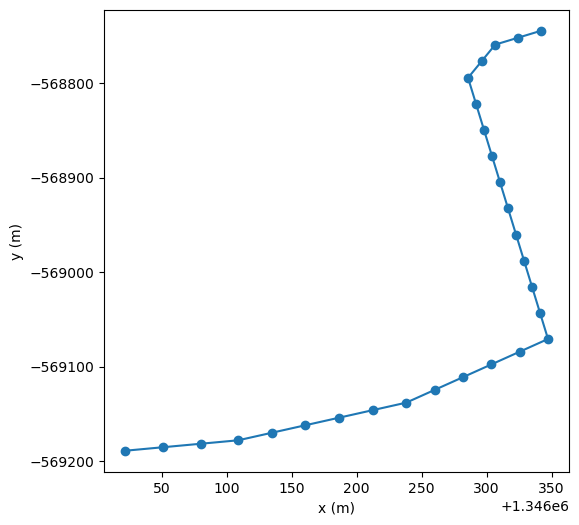

In [214]:
fig = plt.figure(figsize=figsize)
plt.plot(xy_coor[0,:],xy_coor[1,:],'-o')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [285]:
def test():
    """Stupid test function"""
    L = [i for i in range(10000)]

def test2():
    """Stupid test function"""
    L = []
    for i in range(10000):
        L.append(i)

if __name__ == '__main__':
    import timeit
    print(timeit.timeit("test()", setup="from __main__ import test"))
    print(timeit.timeit("test2()", setup="from __main__ import test2"))


138.32254274992738
288.0397943749558


In [282]:
test2()

In [280]:
L

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]